Youtube Comments Summarizer  Pipeline:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import OutputAdapter

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

from src.custom_components.components import ReviewData


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
CSV_PATH = "comments-2024-09-07 22:44:00.473900.csv"

CSV_PATH2 = "comments-2024-09-06 00:57:45.840294.csv"

In [4]:
review_data = ReviewData()

output = review_data.run(csv_file_path=CSV_PATH)
output["reviews"]

[{'author': '@FleetingFilms',
  'comment': 'Oh wow she captures that feeling of missing someone so much that it would almost feel better if they never existed '},
 {'author': '@IkerUnzu',
  'comment': 'Her acting is incredible in this video omg'},
 {'author': '@schmoyoho',
  'comment': 'gonna erase my memory so i can hear this for the first time again'},
 {'author': '@pabloo_.',
  'comment': 'i don’t care of any other opinion, eternal sunshine IS the album of the year.'},
 {'author': '@crazeerathana',
  'comment': 'GIVE EVAN PETERS HIS ROMCOM  let this man be happy and fall in love. Let him breathe. Thank you Ari for fulfilling something he’s been wanting to do'},
 {'author': '@chicken',
  'comment': 'one of her best music videos. so beautiful'},
 {'author': '@mplacencia28',
  'comment': "I love to see Evan smile, he plays so many dark characters (flawlessly, I may add) that it's so relieving to see him play something so light. We need more playful/smiley Evan pleeeease."},
 {'author':

In [5]:
output["reviews"].extend(review_data.run(csv_file_path=CSV_PATH2)["reviews"])
output["reviews"]

[{'author': '@FleetingFilms',
  'comment': 'Oh wow she captures that feeling of missing someone so much that it would almost feel better if they never existed '},
 {'author': '@IkerUnzu',
  'comment': 'Her acting is incredible in this video omg'},
 {'author': '@schmoyoho',
  'comment': 'gonna erase my memory so i can hear this for the first time again'},
 {'author': '@pabloo_.',
  'comment': 'i don’t care of any other opinion, eternal sunshine IS the album of the year.'},
 {'author': '@crazeerathana',
  'comment': 'GIVE EVAN PETERS HIS ROMCOM  let this man be happy and fall in love. Let him breathe. Thank you Ari for fulfilling something he’s been wanting to do'},
 {'author': '@chicken',
  'comment': 'one of her best music videos. so beautiful'},
 {'author': '@mplacencia28',
  'comment': "I love to see Evan smile, he plays so many dark characters (flawlessly, I may add) that it's so relieving to see him play something so light. We need more playful/smiley Evan pleeeease."},
 {'author':

In [6]:
from haystack import Document

docs = []

for review in output['reviews']:
    docs.append(Document(content=review['comment']))

In [7]:
document_store = InMemoryDocumentStore()

embedder = CohereDocumentEmbedder(model="embed-english-v3.0")
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("embedder", "writer")


🚅 Components
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

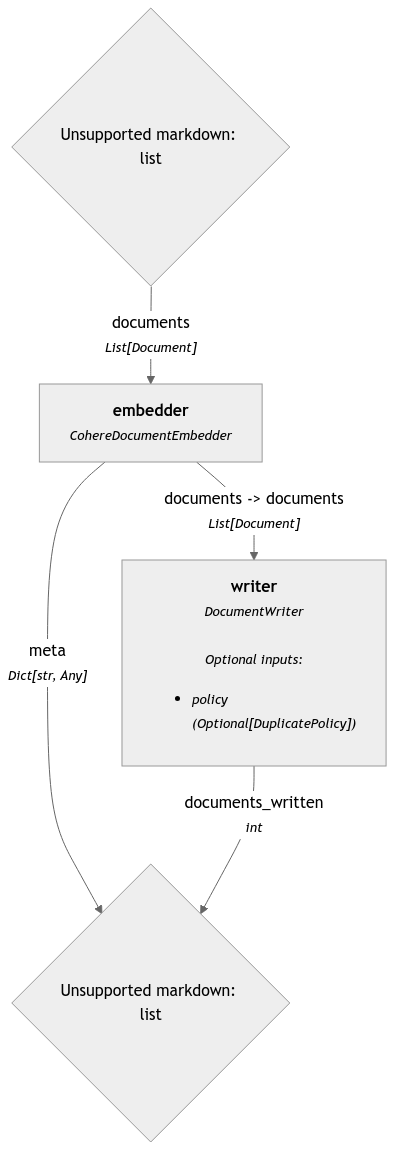

In [8]:
indexing.show()

In [9]:
dialogue1 = indexing.run({"embedder": {"documents":docs}})

print(dialogue1)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=505.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])}, 'writer': {'documents_written': 14}}


In [10]:

print(indexing.dumps())

components:
  embedder:
    init_parameters:
      api_base_url: https://api.cohere.com
      api_key:
        env_vars:
        - COHERE_API_KEY
        - CO_API_KEY
        strict: true
        type: env_var
      batch_size: 32
      embedding_separator: '

        '
      input_type: search_document
      meta_fields_to_embed: []
      model: embed-english-v3.0
      progress_bar: true
      timeout: 120
      truncate: END
      use_async_client: false
    type: haystack_integrations.components.embedders.cohere.document_embedder.CohereDocumentEmbedder
  writer:
    init_parameters:
      document_store:
        init_parameters:
          bm25_algorithm: BM25L
          bm25_parameters: {}
          bm25_tokenization_regex: (?u)\b\w\w+\b
          embedding_similarity_function: dot_product
          index: cfd73f8b-d01b-4498-b0d6-55f8f5b012d1
        type: haystack.document_stores.in_memory.document_store.InMemoryDocumentStore
      policy: NONE
    type: haystack.components.writer

In [11]:
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

generator = AmazonBedrockGenerator(
        model="amazon.titan-text-lite-v1",
        max_length=99
)

In [12]:
template = """You will be provided a few of the top comments for a youtube video. Based on the comments, Summarize people's opinions of the new song.
Comments:  
{% for review in reviews %}
  Comment:\n
  {{ review['author'] }} wrote {{ review['comment'] }}
{% endfor %}  
"""
prompt1 = PromptBuilder(template=template)

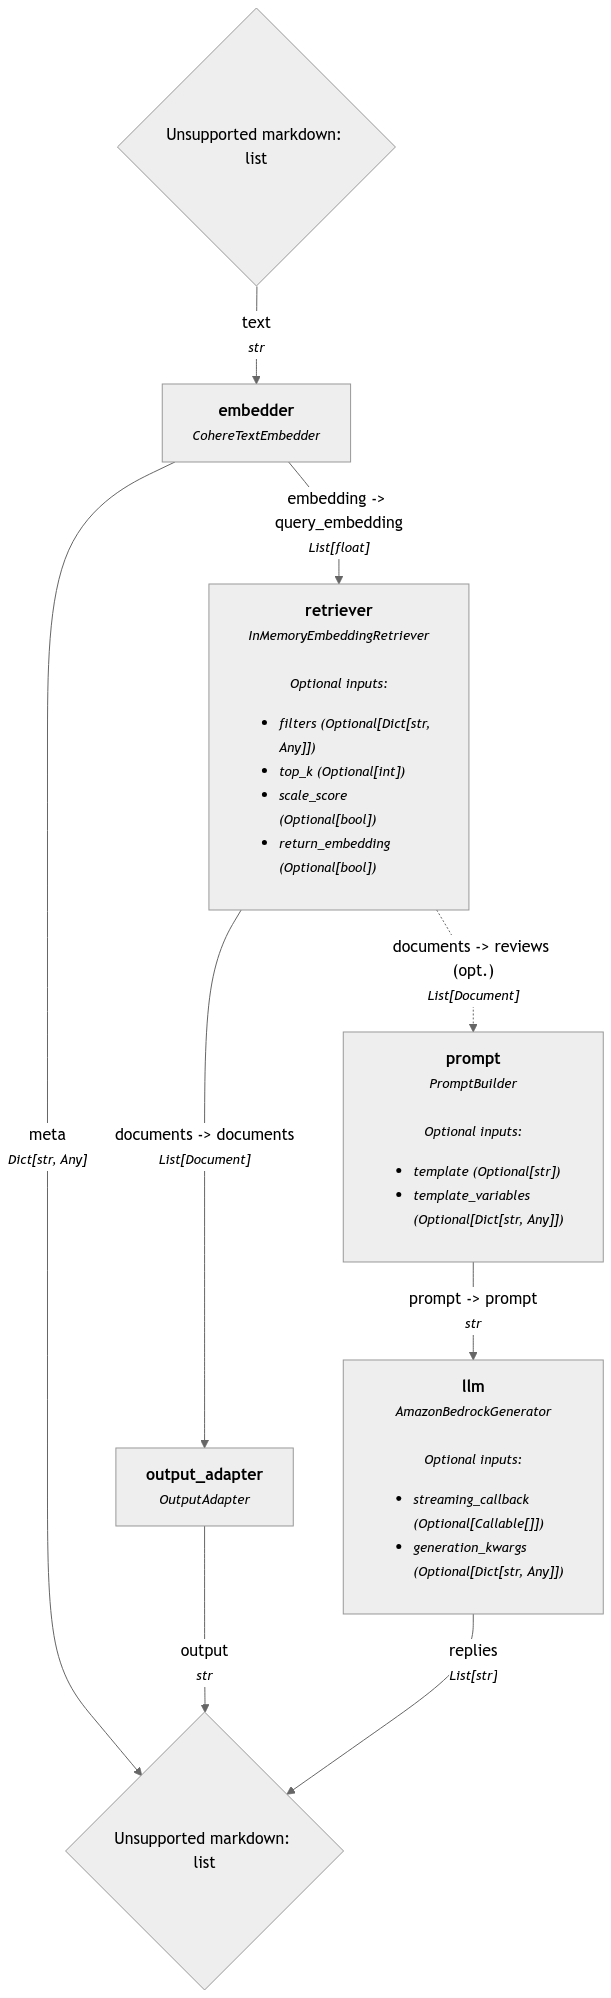

In [13]:

prompt1 = PromptBuilder(template=template)
retriever = InMemoryEmbeddingRetriever(document_store)
embedder = CohereTextEmbedder(model="embed-english-v3.0")

dialogue_builder1 = Pipeline()
dialogue_builder1.add_component("embedder", embedder)
dialogue_builder1.add_component("retriever", retriever)
dialogue_builder1.add_component(
    name="output_adapter",
    instance=OutputAdapter(template="{{ documents }}", output_type=str),
)
dialogue_builder1.add_component("prompt", prompt1)
dialogue_builder1.add_component("llm", generator)

dialogue_builder1.connect("embedder.embedding", "retriever.query_embedding")
dialogue_builder1.connect("retriever.documents", "prompt.reviews")
dialogue_builder1.connect("retriever.documents", "output_adapter")
dialogue_builder1.connect("prompt", "llm")

dialogue_builder1.outputs(True)

dialogue_builder1.show()

In [14]:
question = "You will be provided a few of the top comments for a youtube video. Based on the comments, Summarize people's opinions of Ariana's new song."
dialogue1 = dialogue_builder1.run({"retriever": {"top_k": 8}, "embedder": {"text":question}})

print(dialogue1["llm"]["replies"])



['The comments on the video are mixed. Some people love the song and find it catchy and enjoyable, while others are not as impressed and find it too similar to other popular songs. Overall, it seems that the video has generated a lot of discussion and debate among viewers.']


In [15]:
print(dialogue1["output_adapter"]["output"])

[Document(id=b690f94d9841b41f98d16061d1202a8addc59b186a871af65594bb9ce234e263, content: 'Why is this song emotional ', score: 0.4273178342236097), Document(id=d20306e22fce8233a322a909671827dde4a05050e8b3b7cd58bab8fc47e61da2, content: 'Her acting is incredible in this video omg', score: 0.39762655238422817), Document(id=35a6f05c70683c0e991f23307023601728b39d1eed9fb22c46d82f23ee9c8b4c, content: 'one of her best music videos. so beautiful', score: 0.39671685089263287), Document(id=24c94370f0cfdb527f73843e44e0960ef711021de0d6a461f51cf9bd435dbd1f, content: 'gonna erase my memory so i can hear this for the first time again', score: 0.33547930628337913), Document(id=fc3d643a8905fc07d6b2031aec69d9544660070a38fc07b26c31bc9618dee9d8, content: 'Oh wow she captures that feeling of missing someone so much that it would almost feel better if they...', score: 0.2770262763479978), Document(id=4f7c93dea29200fcda69e95e2228204df1734ec8a0437de5f2eb87929ca25d22, content: 'GIVE EVAN PETERS HIS ROMCOM  let t

In [16]:
print(dialogue_builder1.dumps())

components:
  embedder:
    init_parameters:
      api_base_url: https://api.cohere.com
      api_key:
        env_vars:
        - COHERE_API_KEY
        - CO_API_KEY
        strict: true
        type: env_var
      input_type: search_query
      model: embed-english-v3.0
      timeout: 120
      truncate: END
      use_async_client: false
    type: haystack_integrations.components.embedders.cohere.text_embedder.CohereTextEmbedder
  llm:
    init_parameters:
      aws_access_key_id:
        env_vars:
        - AWS_ACCESS_KEY_ID
        strict: false
        type: env_var
      aws_profile_name:
        env_vars:
        - AWS_PROFILE
        strict: false
        type: env_var
      aws_region_name:
        env_vars:
        - AWS_DEFAULT_REGION
        strict: false
        type: env_var
      aws_secret_access_key:
        env_vars:
        - AWS_SECRET_ACCESS_KEY
        strict: false
        type: env_var
      aws_session_token:
        env_vars:
        - AWS_SESSION_TOKEN
      